![alt text](airbnb-logo.png "Title")
# Airbnb Visualizations
For this section, I will be attempting to apply visualizations on the Airbnb dataset. Off the top of my head, I thought it would be interesting to apply the models to a list-price vs. popularity dataset. There could be interesting groupings such as popular cheap deals and popular premium listings.

To start off, we will load up the data.

In [1]:
import pandas as pd
import numpy as np

# Data sourced from Inside Airbnb (http://insideairbnb.com/get-the-data.html)
# A million thanks to Murray Cox
calendar = pd.read_csv("calendar.csv")
calendar2 = pd.read_csv("calendar2.csv")
listings = pd.read_csv("listings.csv")
listings2 = pd.read_csv("listings2.csv")
nhoods = pd.read_csv("neighbourhoods.csv")
reviews = pd.read_csv("reviews.csv")
reviews2 = pd.read_csv("reviews2.csv")

Currently, I think that we are not done with the listings2 dataset yet. Just to review, we look at the list of data fields again.

In [2]:
list(listings2)

['id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'name',
 'summary',
 'space',
 'description',
 'experiences_offered',
 'neighborhood_overview',
 'notes',
 'transit',
 'thumbnail_url',
 'medium_url',
 'picture_url',
 'xl_picture_url',
 'host_id',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'street',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'city',
 'state',
 'zipcode',
 'market',
 'smart_location',
 'country_code',
 'country',
 'latitude',
 'longitude',
 'is_location_exact',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'bed_type',
 'amenities',
 'square_feet',
 'price',
 'weekly_price',


In [3]:
# for i in range(len(list(listings2))):
#     print i
#     print listings2.columns[i]
#     print listings2[listings2.columns[i]].head()

Glancing through the data, I wondered if it would be intersting to plot the price of listings against popularity. Clustering might put them into interesting archetypes (popular deals vs. premium deals vs. duds, etc.)

To normalize the price, I had intended to use square feet, but the field seems to be mainly NA (hosts probably can't be bothered to input their square feet). So I thought a good idea would be to use the listing price divided by the number of beds available as a proxy. For popularity, we'll just stick with reviews per month.

In [4]:
# to do computations, need to convert price from a string to float, stripping the dollar signs and commas.
listings2.price = listings2.price.replace( '[\$,)]', '', regex=True).replace( '[(]','-', regex=True).astype(float)

In [5]:
listings2['price_per_bed'] = listings2.price / listings2.beds
listings2.price_per_bed.head()

0    350.00
1    150.00
2    119.00
3     79.00
4    173.75
Name: price_per_bed, dtype: float64

Next, we select the two columns into a data frame named cluster_listings.

In [6]:
cluster_listings = listings2[['price_per_bed', 'reviews_per_month']].dropna()

Looking at the summary statistics, It seems that there are some outliers in the data ($10,000 per bed and 11 reviews per month), but by and large I think we should expect a good range of data points.

In [7]:
cluster_listings.describe()

,price_per_bed,reviews_per_month
count,5690.000000,5690.000000
mean,135.602578,1.865921
std,192.674748,1.744574
min,0.000000,0.020000
25%,85.125000,0.570000
50%,120.000000,1.230000
75%,165.000000,2.700000
max,10000.000000,11.520000


At this point, it seems that the data is not panning out as expected. There are some outliers which distort the overall shape of the scatter plot. These listings also hardly get any business.

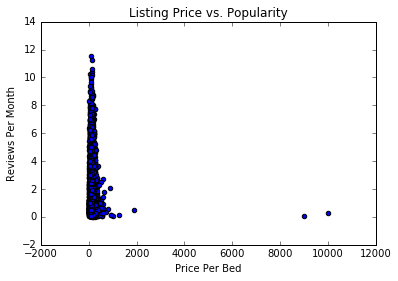

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(cluster_listings.price_per_bed, cluster_listings.reviews_per_month)
plt.xlabel("Price Per Bed")
plt.ylabel("Reviews Per Month")
plt.title("Listing Price vs. Popularity")

Zooming in closer and leaving out the outliers, we can observe that the scatter plot is looking like a radial distribution from around (100, 0) as the center. 

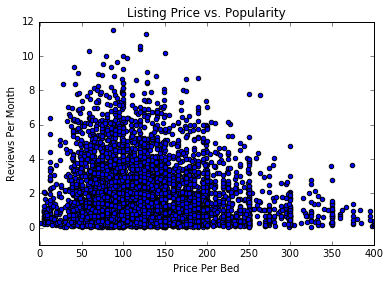

In [9]:
plt.xlim(-1, 400) # there are some outliers, so zoom in to get a better view of the pattern
plt.ylim(-1, 12)
plt.scatter(cluster_listings.price_per_bed, cluster_listings.reviews_per_month)
plt.xlabel("Price Per Bed")
plt.ylabel("Reviews Per Month")
plt.title("Listing Price vs. Popularity")

Lets try to do a density plot to see if we are able to derive insights.

In [10]:
from scipy.stats import gaussian_kde # use Gaussian kernel density distribution to map density

# Calculate the point density
vstacked = np.vstack([cluster_listings.price_per_bed, cluster_listings.reviews_per_month])
density_color = gaussian_kde(vstacked)(vstacked)

# Sort the points by density, so that the densest points are plotted last
idx = density_color.argsort()
cluster_listings.price_per_bed = cluster_listings.price_per_bed[idx]
cluster_listings.reviews_per_month = cluster_listings.reviews_per_month[idx]
density_color = density_color[idx]

It does seem that there is a center where the listings coverge towards. however, this does not seem like a good plot to do clustering with.

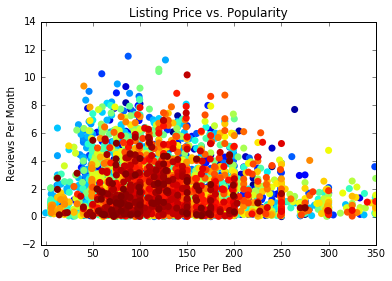

In [11]:
fig, ax = plt.subplots()
ax.scatter(cluster_listings.price_per_bed, cluster_listings.reviews_per_month, c=density_color, s=50, edgecolor='')
plt.xlim(-5, 350)
plt.xlabel("Price Per Bed")
plt.ylabel("Reviews Per Month")
plt.title("Listing Price vs. Popularity")
plt.show()

At this point, it might make some sense to do some k-means clustering on a variety of factors to see if we are able to derive some meaningful patterns. In order to do so, we would need to obtain the set of numeric data fields.

In [12]:
list(listings2.select_dtypes(include=['int64', 'float64']))

['id',
 'scrape_id',
 'host_id',
 'host_listings_count',
 'host_total_listings_count',
 'neighbourhood_group_cleansed',
 'zipcode',
 'latitude',
 'longitude',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'square_feet',
 'price',
 'guests_included',
 'minimum_nights',
 'maximum_nights',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'number_of_reviews',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'calculated_host_listings_count',
 'reviews_per_month',
 'price_per_bed']

Looking at the list, there are some fields like the ids that I would get rid of. Let's try to categorize the data sets into groups that make sense.

The first group will be location/attribute data. We will extract the lat, long, price, and review information of the listings.

In [13]:
listings2_latlong = listings2[[
 'latitude',
 'longitude',
 'review_scores_location',
 'reviews_per_month',
 'price_per_bed']].dropna()

In [14]:
listings2_latlong.head()

,latitude,longitude,review_scores_location,reviews_per_month,price_per_bed
0,37.785217,-122.488655,9,0.28,350.00
2,37.781505,-122.504754,9,2.33,119.00
4,37.781797,-122.492492,10,0.36,173.75
5,37.781564,-122.494424,9,1.13,80.00
6,37.783888,-122.508557,9,6.09,135.00


In [15]:
listings2_latlong.describe()

,latitude,longitude,review_scores_location,reviews_per_month,price_per_bed
count,5619.000000,5619.000000,5619.000000,5619.000000,5619.000000
mean,37.767126,-122.430687,9.425521,1.882073,135.662945
std,0.021308,0.024981,0.846072,1.748740,193.713587
min,37.705137,-122.513065,2.000000,0.020000,0.000000
25%,37.753716,-122.441803,9.000000,0.580000,85.250000
50%,37.767622,-122.426348,10.000000,1.250000,120.000000
75%,37.782362,-122.413651,10.000000,2.730000,165.000000
max,37.829576,-122.365222,10.000000,11.520000,10000.000000


Let's focus on the latlong attributes and try to get a geographical visualization of the listings.

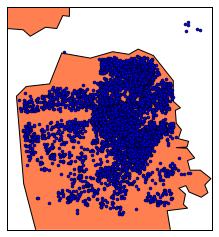

In [16]:
from mpl_toolkits.basemap import Basemap

# minlat, minlong, maxlat, maxlong
minlong, maxlong = -122.513065, -122.365222
minlat, maxlat = 37.705137, 37.829576

map = Basemap(llcrnrlon=minlong-0.01, llcrnrlat=minlat-0.01,
             urcrnrlon=maxlong+0.01, urcrnrlat=maxlat+0.01, projection='merc', resolution='h')

map.drawcoastlines()
map.drawcountries()
map.fillcontinents(color = 'coral')
map.drawmapboundary()

x, y = map(listings2_latlong['longitude'].tolist(), listings2_latlong['latitude'].tolist())
#long first then lat
map.plot(x, y, 'bo', markersize=3)

plt.show()

From the map plot, we can see that there is a central cluster on the upper right region of the map, with some trailing groups on the peripheral radially. there is also a small group on the top left corner of the map, which seems to be at the Oakland/Berkeley area. This looks like a good plot for DBSCAN.

In [17]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=.15, min_samples=5)
X = listings2_latlong[['longitude', 'latitude']]
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
db.fit(X_scaled)

DBSCAN(algorithm='auto', eps=0.15, leaf_size=30, metric='euclidean',
    min_samples=5, p=None, random_state=None)

In [18]:
listings2_latlong['dbscan_clusters'] = db.labels_

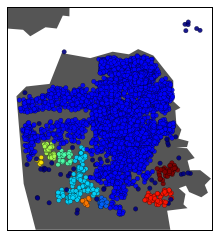

In [19]:
map.fillcontinents(color='#555555')

map.scatter(x, y, c=listings2_latlong.dbscan_clusters, marker='o', lw=0.25, 
            alpha=0.9, zorder=2)
plt.show()

DBSCAN doesn't show up too nicely but there is some semblance of clustering.

-STILL IN PROGRESS-

There is also a fair bit of review data that might be worth looking at. Users are asked to score the listings across various factors, ranging from location, to cleanliness, etc. If we analysed this data more deeply, we may be able to find some patterns.

In [20]:
listings2_price_review = listings2[[
 'price',
 'number_of_reviews',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'reviews_per_month',
 'price_per_bed']].dropna()

Extra: I want to assign a BART station and distance from BART station for each listing

In [21]:
bartstations = pd.read_csv("BARTstations.csv")

In [22]:
bartstations.head()

,name,abbr,latitude,longitude,address,city,county,state,zipcode,Unnamed: 9
0,12th St. Oakland City Center,12TH,37.803664,-122.271604,1245 Broadway,Oakland,alameda,CA,94612,NaN
1,16th St. Mission,16TH,37.765062,-122.419694,2000 Mission Street,San Francisco,sanfrancisco,CA,94110,NaN
2,19th St. Oakland,19TH,37.807870,-122.269029,1900 Broadway,Oakland,alameda,CA,94612,NaN
3,24th St. Mission,24TH,37.752254,-122.418466,2800 Mission Street,San Francisco,sanfrancisco,CA,94110,NaN
4,Ashby,ASHB,37.853024,-122.269780,3100 Adeline Street,Berkeley,alameda,CA,94703,NaN
